<a href="https://colab.research.google.com/github/ManciSee/Sentiment-Analysis-IMDB/blob/main/Sentiment_IMDB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sentiment Analysis IMDB Film Reviews

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import requests
from urllib.request import urlopen as uRequest

In [6]:
from bs4 import BeautifulSoup as soup

url = uRequest("https://www.imdb.com/search/title/?groups=top_100")
page_html = url.read()
page_soup = soup(page_html)

containers = page_soup.findAll('div', {'class' : 'lister-item mode-advanced'})
container = containers[0]
print(container)


<div class="lister-item mode-advanced">
<div class="lister-top-right">
<div class="ribbonize" data-caller="filmosearch" data-tconst="tt15398776"></div>
</div>
<div class="lister-item-image float-left">
<a href="/title/tt15398776/"> <img alt="Oppenheimer" class="loadlate" data-tconst="tt15398776" height="98" loadlate="https://m.media-amazon.com/images/M/MV5BMDBmYTZjNjUtN2M1MS00MTQ2LTk2ODgtNzc2M2QyZGE5NTVjXkEyXkFqcGdeQXVyNzAwMjU2MTY@._V1_UX67_CR0,0,67,98_AL_.jpg" src="https://m.media-amazon.com/images/S/sash/4FyxwxECzL-U1J8.png" width="67"/>
</a> </div>
<div class="lister-item-content">
<h3 class="lister-item-header">
<span class="lister-item-index unbold text-primary">1.</span>
<a href="/title/tt15398776/">Oppenheimer</a>
<span class="lister-item-year text-muted unbold">(I) (2023)</span>
</h3>
<p class="text-muted">
<span class="certificate">R</span>
<span class="ghost">|</span>
<span class="runtime">180 min</span>
<span class="ghost">|</span>
<span class="genre">
Biography, Drama, Hist

# IMDB stampa i titoli in cinese

In [7]:
!pip install translate

# Pulizia totale
Pulizia titolo e nome che avevano caratteri speciali come `\n1.\nOppenheimer\n(I)` e `2023)\n` e order come `1.`



In [8]:
# Funzione per pulire il titolo e l'anno
def clean_title(raw_title):
    # Rimuovi il numero iniziale seguito da un punto e uno spazio
    clean_title = raw_title.split('.', 1)[-1].strip()
    # Rimuovi l'anno tra parentesi alla fine
    clean_title = clean_title.split('(')[0].strip()
    return clean_title

def clean_year(raw_year):
    # Rimuovi eventuali spazi bianchi iniziali e finali
    clean_year = raw_year.strip()
    # Rimuovi il carattere "\n" alla fine
    clean_year = clean_year.rstrip('\n')
    # Rimuovi l'ultima parentesi
    if clean_year.endswith(')'):
        clean_year = clean_year[:-1]
    return clean_year

def clean_order(raw_order):
    # Rimuovi il punto alla fine dell'elemento "order"
    clean_order = raw_order.rstrip('.')
    return clean_order

def clean_review_title(raw_title):
    clean_title = raw_title.strip('\n')
    return clean_title

def clean_score(raw_score):
    # Rimuovi eventuali spazi bianchi iniziali e finali
    clean_score = raw_score.strip()
    # Rimuovi il carattere "\n" se presente
    clean_score = clean_score.replace('\n', '')
    return clean_score

# Tiriamoci tutte cose

In [9]:
from bs4 import BeautifulSoup as soup
from translate import Translator
import requests

# Funzione per tradurre il testo dal cinese all'inglese
def translate_to_english(text):
    translator = Translator(to_lang="en", from_lang="zh")
    translation = translator.translate(text)
    return translation

def extract_link_from_h3(h3_element):
    # Cerca l'elemento <a> all'interno dell'elemento h3
    a_element = h3_element.find('a')
    if a_element:
        link = a_element.get('href')
        return link
    return None

def scrape_review_page(review_url):
    page_html = requests.get(review_url).text
    page_soup = soup(page_html, 'html.parser')
    return page_soup

def scrape_page(url):
    page_html = requests.get(url).text
    page_soup = soup(page_html, 'html.parser')

    containers = page_soup.findAll('div', {'class': 'lister-item mode-advanced'})

    _records = []

    main_page = 1


    for container in containers:
        c_title = container.findAll('h3', {'class': 'lister-item-header'})[0].text
        c_order = container.findAll('span', {'class': 'lister-item-index unbold text-primary'})[0].text
        c_year = c_title[-6:]
        c_title = c_title.replace(c_order + ' ', '')[:-7]
        c_link = extract_link_from_h3(container.find('h3', {'class': 'lister-item-header'}))
        c_score = container.findAll('div', {'class' : 'inline-block ratings-imdb-rating'})[0].text

        c_review_link = 'https://www.imdb.com' + c_link + 'reviews' if c_link else None  # Aggiungi il dominio IMDb al link della recensione

        if c_link and c_link.startswith('/title/'):
            c_link = 'https://www.imdb.com' + c_link

        c_title = clean_title(c_title)
        c_year = clean_year(c_year)
        c_order = clean_order(c_order)
        c_score = clean_score(c_score)

        #Translate the title from Chinese to English if needed
        c_title_english = translate_to_english(c_title)

        # Access the review page and parse it
        if c_review_link:
            review_page_soup = scrape_review_page(c_review_link)

            for review_item in review_page_soup:
                try:
                    review_titles = review_item.findAll('a', {'class': 'title'}) #[:5]
                    review_texts = review_item.findAll('div', {'class': 'text'}) #[:5]

                    if len(review_titles) == 0:
                        _records.append([c_order, c_title_english, c_year, c_link, "No reviews found"])
                    else:
                        for i in range(min(len(review_titles), len(review_texts))):
                            clean_review_title_text = clean_review_title(review_titles[i].text)
                            _records.append([c_order, c_title_english, c_year, c_score, c_link, clean_review_title_text, review_texts[i].text])


                except:
                    continue
    return _records


In [10]:
import pandas as pd
from urllib.request import urlopen as uRequest

url = 'https://www.imdb.com/search/title/?groups=top_100'
records = scrape_page(url)
data = pd.DataFrame(records, columns=['order', 'title', 'year', 'score', 'link', 'review title','review text'])
data.insert(0, 'id', range(1, len(data) + 1))
data.head(26)


,id,order,title,year,score,link,review title,review text
0,1,1,Oppenheimer,2023,8.5,https://www.imdb.com/title/tt15398776/,Murphy is exceptional,You'll have to have your wits about you and yo...
1,2,1,Oppenheimer,2023,8.5,https://www.imdb.com/title/tt15398776/,"A challenging watch to be sure, but a worthwh...",One of the most anticipated films of the year ...
2,3,1,Oppenheimer,2023,8.5,https://www.imdb.com/title/tt15398776/,A brilliantly layered examination of a man th...,"""Oppenheimer"" is a biographical thriller film ..."
3,4,1,Oppenheimer,2023,8.5,https://www.imdb.com/title/tt15398776/,Nolan delivers a powerfull biopic that shows ...,This movie is just... wow! I don't think I hav...
4,5,1,Oppenheimer,2023,8.5,https://www.imdb.com/title/tt15398776/,"Nolan touches greatness, falls slightly short",I was familiar with the Manhattan project and ...
5,6,1,Oppenheimer,2023,8.5,https://www.imdb.com/title/tt15398776/,A Masterpiece,I may consider myself lucky to be alive to wat...
6,7,1,Oppenheimer,2023,8.5,https://www.imdb.com/title/tt15398776/,And the Oscar goes to...,I'm still collecting my thoughts after experie...
7,8,1,Oppenheimer,2023,8.5,https://www.imdb.com/title/tt15398776/,Another Cinematic Masterpiece by Christopher ...,Oppenheimer might be the best film I watched i...
8,9,1,Oppenheimer,2023,8.5,https://www.imdb.com/title/tt15398776/,Exceptional storytelling and Genius Cinametog...,Just came out of the theater and watching Oppe...
9,10,1,Oppenheimer,2023,8.5,https://www.imdb.com/title/tt15398776/,This just might be as interesting as this top...,I'm a big Nolan fan. Maybe this one just wasn'...


# Save data to CSV

In [11]:
print('Saving to CSV...')
data.to_csv('Dataset_IMDB.csv', sep=',', encoding='utf-8')
print('Done!')

Saving to CSV...
Done!


# NLP

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk

plt.style.use('ggplot')

In [13]:
# Read data
df = pd.read_csv('Dataset_IMDB.csv', sep=',')
df.head()

,Unnamed: 0,id,order,title,year,score,link,review title,review text
0,0,1,1,Oppenheimer,2023,8.5,https://www.imdb.com/title/tt15398776/,Murphy is exceptional,You'll have to have your wits about you and yo...
1,1,2,1,Oppenheimer,2023,8.5,https://www.imdb.com/title/tt15398776/,"A challenging watch to be sure, but a worthwh...",One of the most anticipated films of the year ...
2,2,3,1,Oppenheimer,2023,8.5,https://www.imdb.com/title/tt15398776/,A brilliantly layered examination of a man th...,"""Oppenheimer"" is a biographical thriller film ..."
3,3,4,1,Oppenheimer,2023,8.5,https://www.imdb.com/title/tt15398776/,Nolan delivers a powerfull biopic that shows ...,This movie is just... wow! I don't think I hav...
4,4,5,1,Oppenheimer,2023,8.5,https://www.imdb.com/title/tt15398776/,"Nolan touches greatness, falls slightly short",I was familiar with the Manhattan project and ...


# Semplice analisi esplorativa

<Axes: title={'center': 'Count of reviews by score'}>

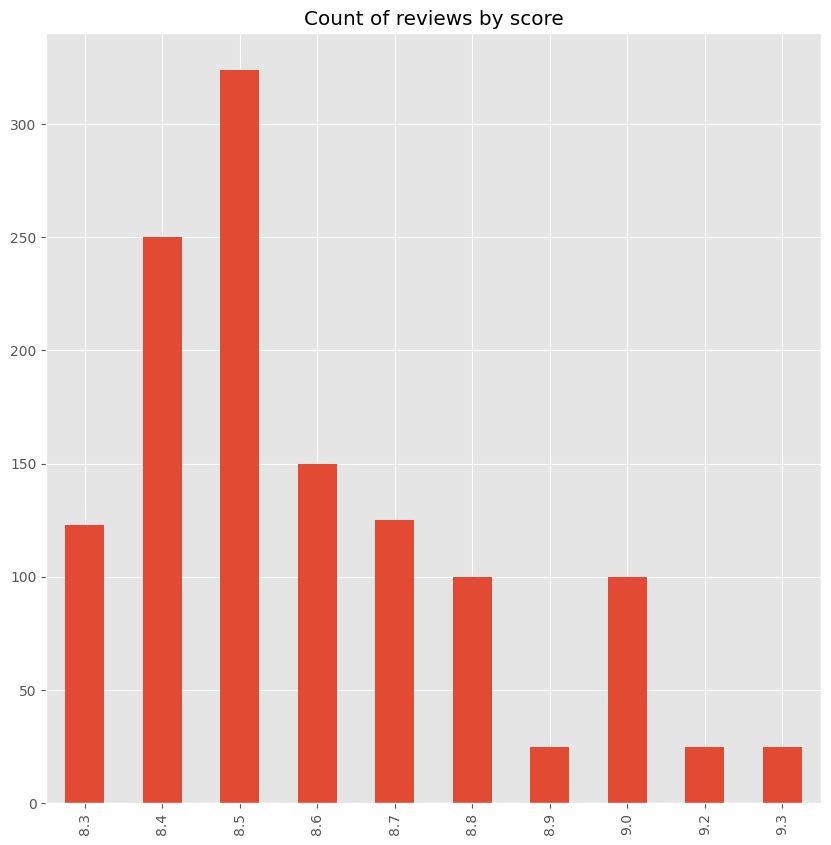

In [14]:
df['score'].value_counts().sort_index().plot(kind='bar', title='Count of reviews by score', figsize=(10,10))

# NLTK

In [15]:
example = df['review text'][20]
print(example)

I'm a big fan of Nolan's work so was really looking forward to this. I understood there would be some flipping in timelines and I'd need to concentrate. I didn't find this to be a problem at all and the storytelling was beautifully done. The acting was universally excellent. I saw a review saying Emily Blunt was rather OTT but I didn't find that at all.I think my biggest gripe with the film may mean that I'm just getting old. I found the direction quite jarring with jump cuts galore. While it did keep things moving along apace, it was all rather exhausting. I also found the music and sound very very loud to the point of intrusion. Much like other Nolan films as it goes: Interstellar that I love, also had *very* loud music.All in all this is a quality watch. It just left me longing for the days when so called 'cerebral' biopics, were a little more tranquil.


In [17]:
nltk.download('punkt')

tokens = nltk.word_tokenize(example)
tokens[:10]

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


['I', "'m", 'a', 'big', 'fan', 'of', 'Nolan', "'s", 'work', 'so']

# Tagging

Here there are some [POS example](https://www.guru99.com/pos-tagging-chunking-nltk.html)

In [18]:
nltk.download('averaged_perceptron_tagger')

tagged = nltk.pos_tag(tokens)
tagged[:10]

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


[('I', 'PRP'),
 ("'m", 'VBP'),
 ('a', 'DT'),
 ('big', 'JJ'),
 ('fan', 'NN'),
 ('of', 'IN'),
 ('Nolan', 'NNP'),
 ("'s", 'POS'),
 ('work', 'NN'),
 ('so', 'RB')]

# Chunk the list of tokens

In [19]:
nltk.download('maxent_ne_chunker')
nltk.download('words')

entities = nltk.chunk.ne_chunk(tagged)
entities.pprint()

[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping chunkers/maxent_ne_chunker.zip.
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Unzipping corpora/words.zip.


(S
  I/PRP
  'm/VBP
  a/DT
  big/JJ
  fan/NN
  of/IN
  (PERSON Nolan/NNP)
  's/POS
  work/NN
  so/RB
  was/VBD
  really/RB
  looking/VBG
  forward/RB
  to/TO
  this/DT
  ./.
  I/PRP
  understood/VBD
  there/EX
  would/MD
  be/VB
  some/DT
  flipping/NN
  in/IN
  timelines/NNS
  and/CC
  I/PRP
  'd/MD
  need/VB
  to/TO
  concentrate/VB
  ./.
  I/PRP
  did/VBD
  n't/RB
  find/VB
  this/DT
  to/TO
  be/VB
  a/DT
  problem/NN
  at/IN
  all/DT
  and/CC
  the/DT
  storytelling/NN
  was/VBD
  beautifully/RB
  done/VBN
  ./.
  The/DT
  acting/NN
  was/VBD
  universally/RB
  excellent/JJ
  ./.
  I/PRP
  saw/VBD
  a/DT
  review/NN
  saying/VBG
  (PERSON Emily/NNP Blunt/NNP)
  was/VBD
  rather/RB
  OTT/NNP
  but/CC
  I/PRP
  did/VBD
  n't/RB
  find/VB
  that/DT
  at/IN
  all.I/RB
  think/VB
  my/PRP$
  biggest/JJS
  gripe/NN
  with/IN
  the/DT
  film/NN
  may/MD
  mean/VB
  that/IN
  I/PRP
  'm/VBP
  just/RB
  getting/VBG
  old/JJ
  ./.
  I/PRP
  found/VBD
  the/DT
  direction/NN
  quite/RB
  jar

# Step 1: VADER Sentiment Scoring
`SentimentIntensityAnalyzer` from `nltk` use a "bag of words" approach:
1. Stop words are removed;
2. Each word is scored and combined to a total score

In [21]:
from nltk.sentiment import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')

sia = SentimentIntensityAnalyzer()
sia

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


# Example of Polarity

In [22]:
# positive
sia.polarity_scores("Go Catania, win")

{'neg': 0.0, 'neu': 0.345, 'pos': 0.655, 'compound': 0.5859}

In [23]:
# negative
sia.polarity_scores('This is the worst film ever!')

{'neg': 0.468, 'neu': 0.532, 'pos': 0.0, 'compound': -0.6588}

In [24]:
sia.polarity_scores(example)

{'neg': 0.055, 'neu': 0.843, 'pos': 0.102, 'compound': 0.8258}

# Add the polarity on the dataset

In [25]:
from tqdm.notebook import tqdm

res = {}
for i, row in tqdm(df.iterrows(), total=len(df)):
    text = row['review text']
    id = row['id']
    #print(f"Processing row {i}: id={id}, text={text}")
    res[id] = sia.polarity_scores(text)


  0%|          | 0/1247 [00:00<?, ?it/s]

In [26]:
pd.DataFrame(res).T.head(26)

,neg,neu,pos,compound
1,0.050,0.766,0.184,0.9902
2,0.049,0.714,0.237,0.9975
3,0.096,0.755,0.149,0.9987
4,0.061,0.713,0.226,0.9908
5,0.032,0.856,0.113,0.9879
6,0.046,0.783,0.171,0.9253
7,0.065,0.811,0.125,0.8765
8,0.032,0.798,0.170,0.9861
9,0.023,0.690,0.287,0.9958
10,0.081,0.766,0.153,0.9939


In [28]:
vaders = pd.DataFrame(res).T
vaders = vaders.reset_index().rename(columns={'index' : 'id'})
vaders = vaders.merge(df, how='left')

vaders.to_csv('IMDB_sentiment.csv', index=False)

# Now there are sentiment score and metadata

In [29]:
vaders.head()

,id,neg,neu,pos,compound,Unnamed: 0,order,title,year,score,link,review title,review text
0,1,0.050,0.766,0.184,0.9902,0,1,Oppenheimer,2023,8.5,https://www.imdb.com/title/tt15398776/,Murphy is exceptional,You'll have to have your wits about you and yo...
1,2,0.049,0.714,0.237,0.9975,1,1,Oppenheimer,2023,8.5,https://www.imdb.com/title/tt15398776/,"A challenging watch to be sure, but a worthwh...",One of the most anticipated films of the year ...
2,3,0.096,0.755,0.149,0.9987,2,1,Oppenheimer,2023,8.5,https://www.imdb.com/title/tt15398776/,A brilliantly layered examination of a man th...,"""Oppenheimer"" is a biographical thriller film ..."
3,4,0.061,0.713,0.226,0.9908,3,1,Oppenheimer,2023,8.5,https://www.imdb.com/title/tt15398776/,Nolan delivers a powerfull biopic that shows ...,This movie is just... wow! I don't think I hav...
4,5,0.032,0.856,0.113,0.9879,4,1,Oppenheimer,2023,8.5,https://www.imdb.com/title/tt15398776/,"Nolan touches greatness, falls slightly short",I was familiar with the Manhattan project and ...


# Plot VADER results

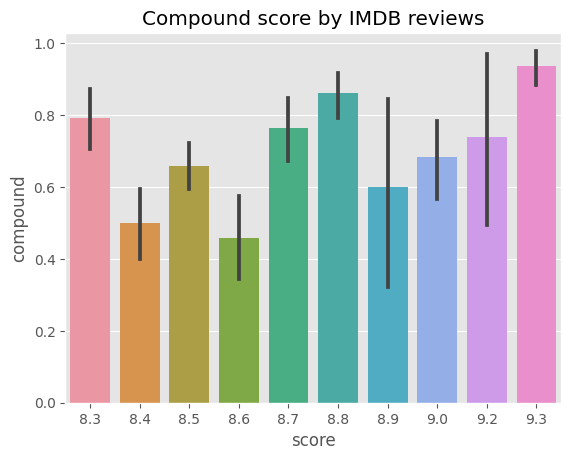

In [30]:
ax = sns.barplot(data=vaders, x='score', y='compound')
ax.set_title('Compound score by IMDB reviews')
plt.show()

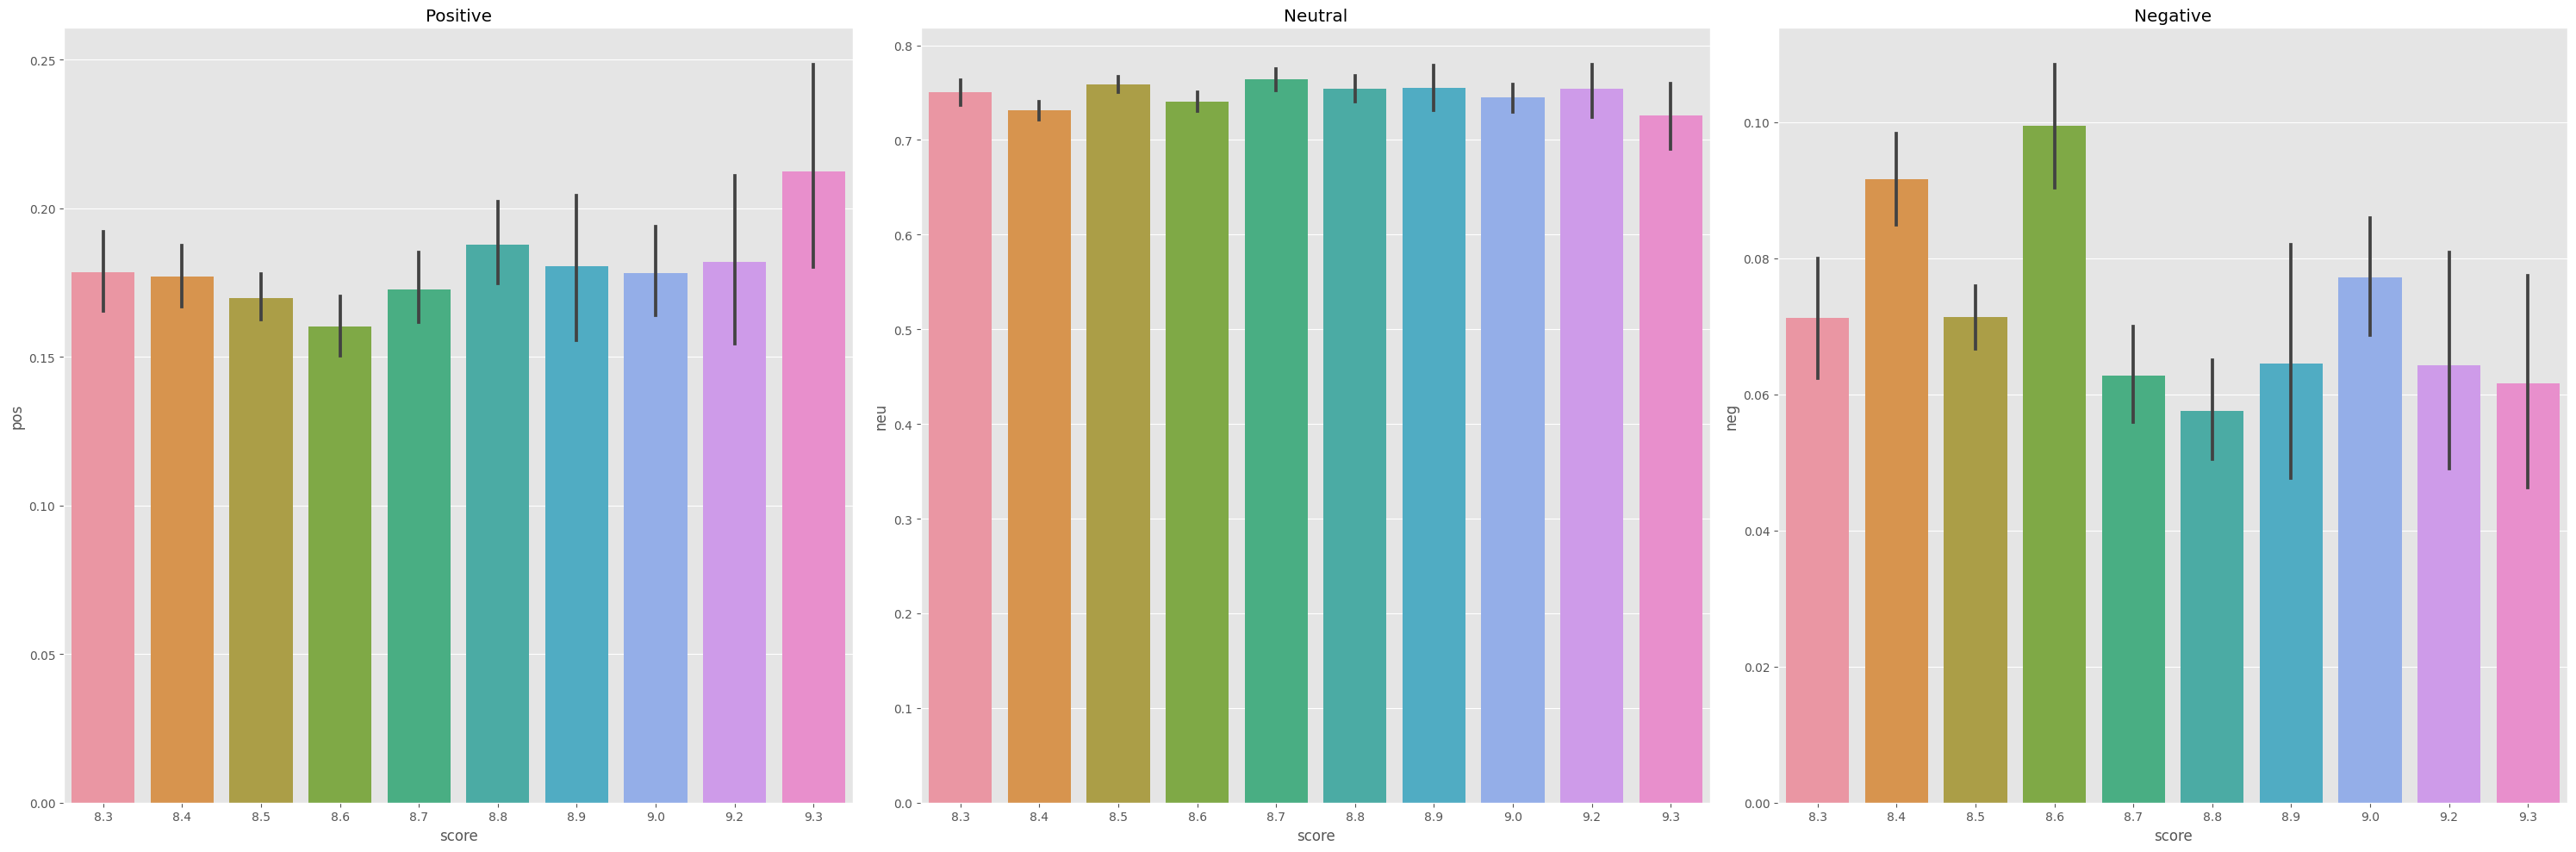

In [31]:
fig, axs = plt.subplots(1, 3, figsize=(30,10))
sns.barplot(data = vaders, x='score', y='pos', ax=axs[0])
sns.barplot(data = vaders, x='score', y='neu', ax=axs[1])
sns.barplot(data = vaders, x='score', y='neg', ax=axs[2])
axs[0].set_title('Positive')
axs[1].set_title('Neutral')
axs[2].set_title('Negative')

plt.tight_layout()

# Wordcloud

In [38]:
from wordcloud import WordCloud
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv('IMDB_sentiment.csv')


# Positive words


In [39]:
positive_df = df[df['compound']>0]
positive_text = ' '.join(positive_df['review text'])

# Negative words


In [40]:
negative_df = df[df['compound']<0]
negative_text = ' '.join(negative_df['review text'])

## Create word cloud

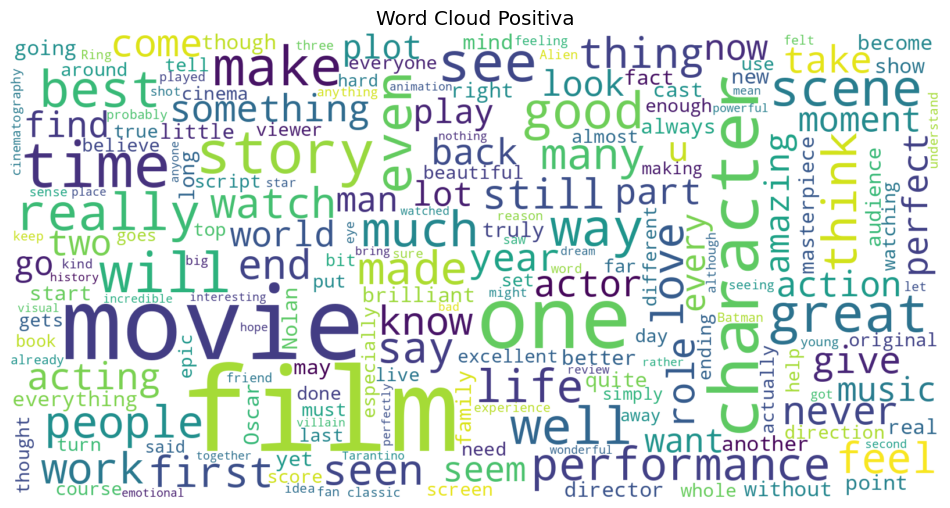

In [64]:
positive_wordcloud = WordCloud(width=1600, height=800, max_font_size=200, background_color='white').generate(positive_text)

plt.figure(figsize=(12, 10))

plt.imshow(positive_wordcloud, interpolation='bilinear')
plt.title('Word Cloud Positiva')
plt.axis('off')

plt.show()


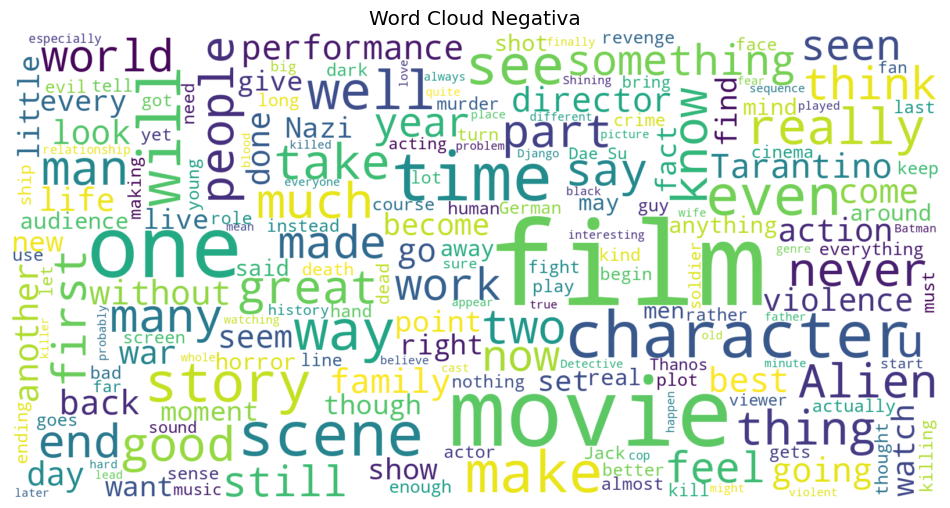

In [65]:
negative_wordcloud = WordCloud(width=1600, height=800, max_font_size=200, background_color='white').generate(negative_text)

plt.figure(figsize=(12, 10))

plt.imshow(negative_wordcloud, interpolation='bilinear')
plt.title('Word Cloud Negativa')
plt.axis('off')

plt.show()